In [14]:
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from core.data import PneumoniaDataModule
from core.model import PneumoniaDetector
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from torch.nn import functional as F
from torchvision import models

## Feature extractor

We want to use `DenseNet` as a feature extractor *only*, without modifying any of the pre-trained weights. For each input image, we get a $1000 \times 1$ feature vector. These features are then fed into three models to compare against the binary/multi-classifiers we previously built.

In [2]:
# Freeze layers from the pre-trained DenseNet model
backbone = models.densenet121(pretrained=True)
backbone.cuda()

for param in backbone.parameters():
    param.requires_grad = False
backbone.eval();

In [3]:
# Load image labels and extracted features
data_dir = Path("./chest_xray").expanduser().resolve()

# Load images
dm = PneumoniaDataModule(
    data_dir,
    batch_size=64,
    num_workers=16,
)
dm.setup("fit")
dm.setup("test")

# Use feature extractor to get n by 1000 X data frame
X_train, y_train = [], []
for batch in dm.train_dataloader():
    imgs, labels = batch
    feat = backbone(imgs.cuda())

    X_train.append(feat)
    y_train.append(labels)
for batch in dm.val_dataloader():
    imgs, labels = batch
    feat = backbone(imgs.cuda())

    X_train.append(feat)
    y_train.append(labels)

X_train = torch.cat(X_train).cpu().numpy()
y_train = torch.cat(y_train).cpu().numpy()

# Do the same thing to prepare the test set
# We also save the imgs for later use
img_test, X_test, y_test = [], [], []
for batch in dm.test_dataloader():
    imgs, labels = batch
    imgs = imgs.to("cuda:0")
    feat = backbone(imgs)

    img_test.append(imgs)
    X_test.append(feat)
    y_test.append(labels)

img_test = torch.cat(img_test)
X_test = torch.cat(X_test).cpu().numpy()
y_test = torch.cat(y_test).cpu().numpy()

del imgs, labels, feat

In [4]:
# Standardize features
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [5]:
res = {}

# Logistic regression
clf = LogisticRegressionCV(
    max_iter=1000, cv=3, class_weight="balanced", random_state=42
)
clf.fit(X_train, y_train)
res["Logistic regression"] = clf

In [6]:
# Linear SVM classifier
clf = LinearSVC(C=0.01, class_weight="balanced", random_state=42)

clf.fit(X_train, y_train)
res["SVM"] = clf

In [7]:
# LightGBM
# estimator = lgb.LGBMClassifier(
#     num_leaves=31,
#     class_weight="balanced",
#     random_state=42,
# )

# param_grid = {
#     "learning_rate": [0.001, 0.01, 0.1, 1],
#     "n_estimators": [20, 40, 80, 160],
# }

# gbm = GridSearchCV(estimator, param_grid, cv=3)
# gbm.fit(X_train, y_train)

# print(f"Best parameters for LightGBM: {gbm.best_params_}")

clf = lgb.LGBMClassifier(
    num_leaves=31,
    class_weight="balanced",
    random_state=42,
    learning_rate=0.1,
    n_estimators=160,
)
clf.fit(X_train, y_train)
res["LightGBM"] = clf

In [8]:
for name, clf in res.items():
    print(name)
    print(confusion_matrix(y_test, clf.predict(X_test)))

Logistic regression
[[136  98]
 [  7 383]]
SVM
[[142  92]
 [  9 381]]
LightGBM
[[119 115]
 [  4 386]]


## Tough samples

Those numbers are similar to the best-performing model in our binary classifier, which makes me wonder if the false positives across models are the same samples.

In [9]:
bin_checkpoints = Path("./model_weights/aug_model.pt.ckpt").expanduser().resolve()
model = PneumoniaDetector.load_from_checkpoint(bin_checkpoints).cuda()

In [17]:
# Construct a DataFrame with true labels and predicted labels from each model
model.freeze()
y_hat = model(img_test)
y_pred = F.log_softmax(y_hat, dim=1).argmax(dim=1)

# labels = sorted(datamod.class_to_idx.keys())
# mat = confusion_matrix(y_true, y_pred, labels=sorted(datamod.class_to_idx.values()))
# res = pd.DataFrame(mat, columns=labels, index=labels)
# res.index = [f"True {x}" for x in res.index]
# res.columns = [f"Predicted {x}" for x in res.columns]

y_models = pd.DataFrame({"y": y_test, "bin_nn_model": y_pred.detach().cpu().numpy()})

for name, clf in res.items():
    y_models[name] = clf.predict(X_test)

In [50]:
fp = (
    y_models.query("y == 0")
    .drop(columns="y")
    .value_counts()
    .reset_index()
    .reset_index(drop=True)
    .rename(columns={0: "Count", "bin_nn_model": "Binary NN classifier"})
)

fp

,Binary NN classifier,Logistic regression,SVM,LightGBM,Count
0,0,0,0,0,97
1,1,1,1,1,71
2,0,0,0,1,19
3,0,1,1,1,11
4,1,0,0,0,10
5,1,0,0,1,9
6,0,1,1,0,5
7,1,1,0,1,5
8,1,1,1,0,4
9,0,0,1,0,1


In [86]:
tough_imgs = y_models.query(
    "y == 0 & bin_nn_model == `Logistic regression` == SVM == LightGBM == 1"
).index.tolist()
easy_imgs = y_models.query(
    "y == bin_nn_model == `Logistic regression` == SVM == LightGBM == 0"
).index.tolist()
pneumonia_imgs = y_models.query(
    "y == bin_nn_model == `Logistic regression` == SVM == LightGBM == 1"
).index.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


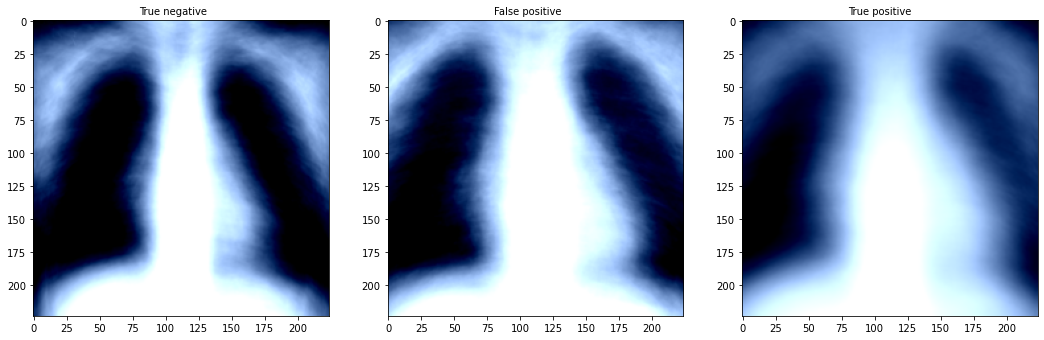

In [88]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axs[0].imshow(img_test[easy_imgs].mean(axis=0).permute(1, 2, 0).cpu())
axs[1].imshow(img_test[tough_imgs].mean(axis=0).permute(1, 2, 0).cpu())
axs[2].imshow(img_test[pneumonia_imgs].mean(axis=0).permute(1, 2, 0).cpu())

for i, x in enumerate(["True negative", "False positive", "True positive"]):
    axs[i].text(80, -5, x)

[ax.set_axis_off() for ax in axs.ravel()]
plt.savefig("avg_normals_test_set.pdf", bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

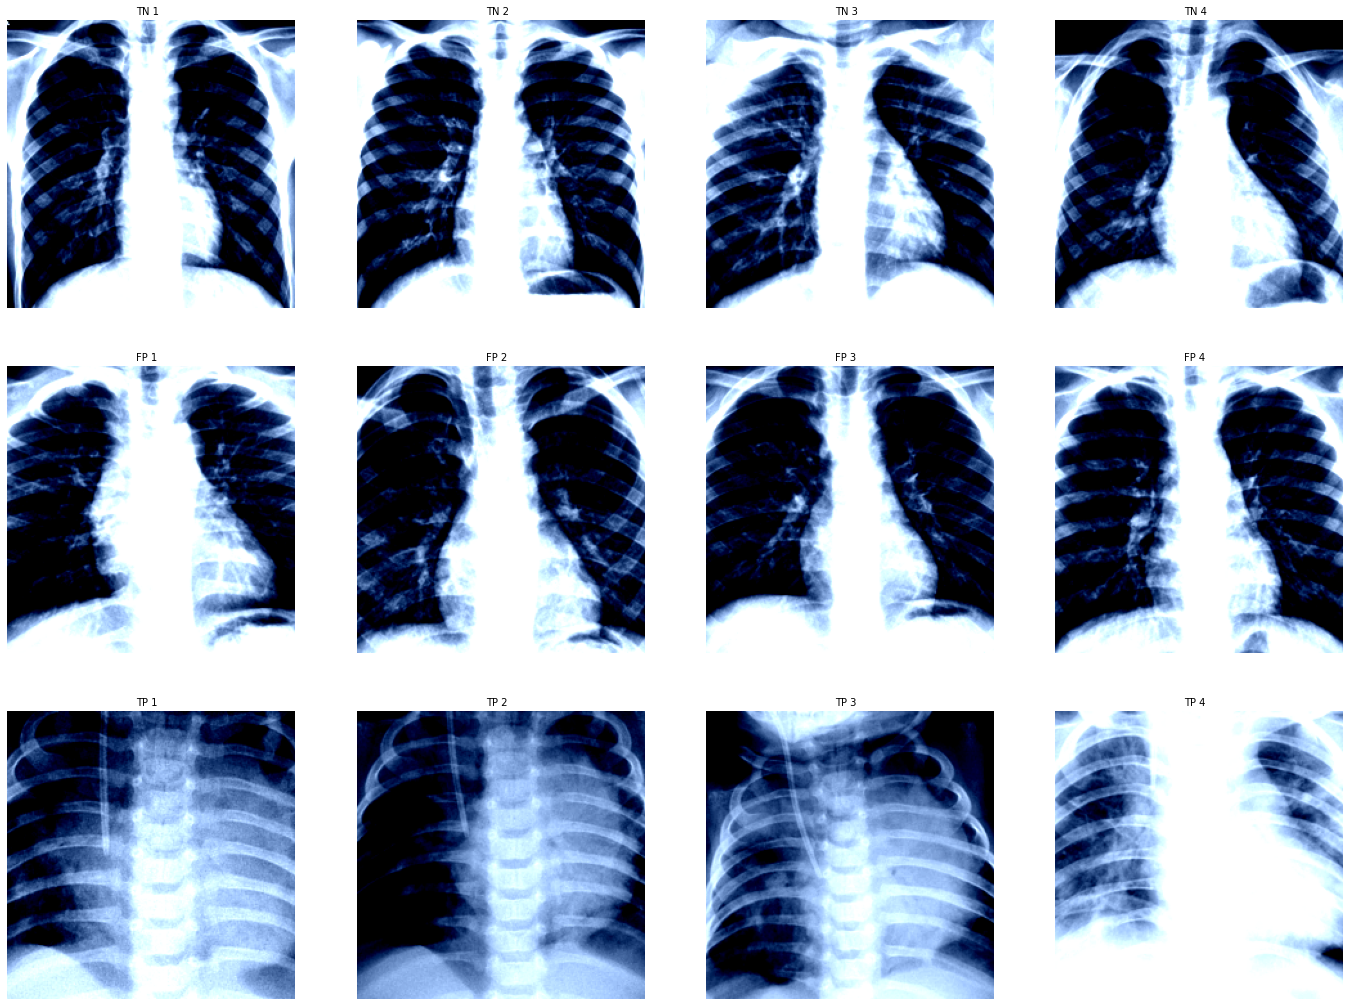

In [94]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(24, 18))

for i in range(4):
    axs[0, i].imshow(img_test[easy_imgs[i]].permute(1, 2, 0).cpu())
    axs[1, i].imshow((img_test[tough_imgs[i]].permute(1, 2, 0).cpu()))
    axs[2, i].imshow((img_test[pneumonia_imgs[i + 4]].permute(1, 2, 0).cpu()))
    axs[0, i].text(100, -5, f"TN {i+1}")
    axs[1, i].text(100, -5, f"FP {i+1}")
    axs[2, i].text(100, -5, f"TP {i+1}")

[ax.set_axis_off() for ax in axs.ravel()]
plt.savefig("sample_normals_test_set.pdf", bbox_inches="tight")